# explained variance curve

In [1]:
import os
import pandas as pd
import json
from glob import glob
import string
import datetime as dt

import nltk
from nltk.tokenize import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer 

In [29]:
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tweet_df = pd.DataFrame(columns = ['date', 'text', 'hashtags'])
for file in glob('data2/*.json'):
    with open(file) as f:
        file_data = json.load(f)
        df = pd.DataFrame(data=file_data)
        tweet_df = pd.concat([tweet_df, df], sort=False, ignore_index=True)

In [3]:
tweet_df['text'] = tweet_df['text'].apply(lambda x: x.replace('\n', ' '))
tweet_df['text'] = tweet_df['text'].apply(lambda x: x.replace('RT', ' '))
tweet_df['text'] = tweet_df['text'].map(lambda x: re.sub(r'\bhttps\S*\b', '', x))
tweet_df['text'] = tweet_df['text'].map(lambda x: re.sub(r'\bpic\S*\b', '', x))
tweet_df['text'] = tweet_df['text'].map(lambda x: re.sub(r'\b@\S*\b', '', x))
tweet_df['text'] = tweet_df['text'].map(lambda x: re.sub(r'[^A-Za-z ]+', '', x))
tweet_df['text'] = tweet_df['text'].map(lambda x: x.lower())
tweet_df = tweet_df.drop_duplicates(subset= ['text'])

In [4]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
lemma_text = lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
tweet_df['text'] = tweet_df['text'].apply(lemma_text)


In [5]:
stop_words = set(nltk.corpus.stopwords.words('english'))

stop_words = stop_words.union(set(['en', 'que', 'para', 'por', 'le', 'de', 'con', 'wa', 'ha', 'im', 'da', 'na'
                                   'un', 'se', 'el', 'su', 'una', 'del', 'al', 'lo', 'la', 
                                   'los', 'th', 'ahora', 'menos', 'dubnation', 'menofcolor', 
                                   'menofinstagram', 'menoninstagram', 'melanin', 'beardgang', 'national', 'basketball', 'association',
                                   'nba', 'let', 'go', 'dub']))

In [6]:
cv_nmf = CountVectorizer(stop_words=stop_words, ngram_range=(2,3), min_df = 10, max_df = 0.85)
vectorized_nmf = cv_nmf.fit_transform(tweet_df['text'])

In [9]:
def get_score(model, data, scorer=metrics.explained_variance_score):
    """ Estimate performance of the model on the data """
    prediction = model.inverse_transform(model.transform(data))
    return scorer(data, prediction)

In [23]:
vectorized_nmf = vectorized_nmf.toarray()

In [24]:
X_train, X_test = model_selection.train_test_split(vectorized_nmf, test_size=0.5, random_state=1)
# I scale the data in order to give equal importance to all its dimensions
# NMF does not allow negative input, so I don't center the data
scaler = preprocessing.StandardScaler(with_mean=False).fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)
# train the both decomposers
nmf = decomposition.NMF(n_components=2).fit(X_train_sc)

In [26]:
ks = [i+1 for i in range(10)]
perfs_train = []
perfs_test = []
for k in ks:
    nmf = decomposition.NMF(n_components=k).fit(X_train_sc)
    perfs_train.append(get_score(nmf, X_train_sc))
    perfs_test.append(get_score(nmf, X_test_sc))
print(perfs_train)
print(perfs_test)

[0.005812036904422133, 0.010420275825870124, 0.014969615254290395, 0.019103795442632396, 0.023051418539017432, 0.02656850041451754, 0.029996094064694532, 0.03337152576825337, 0.03660075834567681, 0.039647392186214554]
[0.00542489495452989, 0.009930551653478874, 0.014489433826137795, 0.018073444592168676, 0.022124411564609685, 0.024211052972932984, 0.02733297021973332, 0.029771052561581798, 0.033037286533394467, 0.03597986480444934]


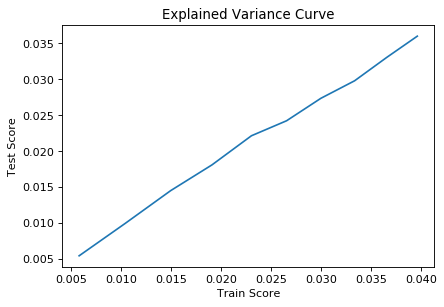

In [30]:
plt.figure(dpi=80)
plt.plot(perfs_train, perfs_test)
plt.xlabel("Train Score")
plt.ylabel("Test Score")
plt.title("Explained Variance Curve");
#plt.savefig('precision recall curve', transparent = True)